### 분석 기법
#### 1. 최소 단위는 그리드(100m * 100m) 단위로 진행
#### 2. 입지 선정 시 고려사항들을 독립변수로 하여 각 관측값들의 연산을 통해 각 그리드 당 점수로 변환
  - 2.1 연산은 분석 기법 내지 수식을 통해 수행할 것
#### 3. 하천, 비행금지구역 등 UAM 이착륙이 불가능한 지역은 제외할 것
  - 예를 들어, 산지천, 돈내코와 같은 하천 지역은 제외 (곶자왈 보류)
#### 4. 입지 선정 시 버티포트, 버티스탑을 나눠서 진행할 것 

### 헬리포트, 주차장이 있으면 저비용 측면을 더 고려한다.

- 버스 정류장
  - 사람이 1시간에 4km
  - 10분이면 660m
  - 버장 기준 300m, 600m 버퍼를 잡아서
 
한 격자당 버스정류장들의 거리를 구해 -> 제일 가까운 버장과의 거리 -> 300m 이내에 있다 660m 이내에 있다 --> 점수 지급

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['figure.figsize'] = (13,13)
plt.rcParams['font.family'] = 'Malgun Gothic'

warnings.filterwarnings("ignore")

---------------------------------------------------------------------------------------------------
# 1. 데이터 로드 및 전처리

#### 1-1 ) 교통 수요 측면 : 표준노드링크
- 링크와 링크ID 별 교통량
- link_id : 링크ID
- F_NODE : 출발 노드ID
- T_NODE : 도착 노드ID
- LANES : 차로수
- ROAD_RANK : 도로 등급
- ROAD_TYPE : 도로 유형
- ROAD_NO : 도로 번호
- ROAD_NAME : 도로명
- ROAD_USE : 도로사용여부
- MULTI_LINK : 중용구간여부
- CONNECT : 연결로코드
- MAX_SPD : 최고제한속도
- REST_VEH : 통행제한차량
- REST_W : 통과제한하중
- REST_H : 통과제한높이
- REMARK : 비고

In [2]:
# 제주링크_shp 불러오기
link_ = './데이터/표준노드링크/제주_링크.shp'
link = gpd.read_file(link_, geometry = 'geometry', encoding='utf-8')
link.geometry = link.geometry.set_crs('EPSG:5179')

#### 1-2 ) 교통 수요 측면 : 표준노드링크단위 교통량
- link_id : 링크ID
- prcn_dt : 데이터 생성일자
- tfvl : 교통량
- sped : 평균속도
- ocpy_rate : 점유율
- trvl_hh : 통행시간

In [3]:
# 표준노드링크별 교통량 불러오기
link_traf = pd.read_csv('./데이터/표준노드링크/표준노드링크_교통량.csv', encoding = 'utf-8')
link_traf.head()

,Unnamed: 0,link_id,prcn_dt,tfvl,sped,ocpy_rate,trvl_hh
0,0,4050175900,20230825231000,0,53,0,3
1,1,4050021604,20230825231000,0,50,0,30
2,2,4050021603,20230825231000,0,53,0,5
3,3,4050021602,20230825231000,0,53,0,5
4,4,4060013702,20230825231000,0,74,0,21


In [4]:
link_traf.drop(['Unnamed: 0', 'prcn_dt'], axis = 1, inplace = True)

In [5]:
link = link.rename(columns={'LINK_ID': 'link_id'})
link['link_id'] = link['link_id'].astype(str)
link_traf['link_id'] = link_traf['link_id'].astype(str)
link_merge = pd.merge(link, link_traf, on='link_id', how='outer')

In [6]:
link_merge.fillna(0, axis = 1, inplace = True) # 결측치 0으로 대체

In [7]:
link_merge = gpd.GeoDataFrame(link_merge, geometry = 'geometry')
link_merge.geometry = link_merge.geometry.set_crs('EPSG:5179')

In [8]:
def to_astype(df, cols, dtype):
    for col in cols:
        df[col] = df[col].astype(dtype)
    return df
link_merge = to_astype(link_merge, ['tfvl','sped', 'ocpy_rate', 'trvl_hh'], 'float')

#### 2 ) 인구측면 : 생산가능인구
  - 100 X 100m 그리드 단위로, 그리드 단위 분석의 기초가 된다.
  - gid : 격자번호
  - lbl : 인구수의 소수점 셋째자리에서 반올림한 값
  - val : 생산가능인구수 (15 ~ 64세 이하)

In [9]:
# 생산가능 인구
pop_ = './데이터/생산가능인구/제주도_생산가능인구.shp'
pop = gpd.read_file(pop_, encoding = 'utf-8')
pop.geometry = pop.geometry.set_crs('EPSG:5179')
pop.head()

,gid,lbl,val,layer,path,geometry
0,다나471969,10.00,10.0,nlsp_021001007,C:\Users\dnjse\OneDrive\바탕 화면\버티포트설계\입지선정\데이터\...,"POLYGON ((947100.000 1496900.000, 947100.000 1..."
1,다나151764,N/A,0.0,nlsp_021001007,C:\Users\dnjse\OneDrive\바탕 화면\버티포트설계\입지선정\데이터\...,"POLYGON ((915100.000 1476400.000, 915100.000 1..."
2,다나032749,N/A,0.0,nlsp_021001007,C:\Users\dnjse\OneDrive\바탕 화면\버티포트설계\입지선정\데이터\...,"POLYGON ((903200.000 1474900.000, 903200.000 1..."
3,다나002742,107.00,107.0,nlsp_021001007,C:\Users\dnjse\OneDrive\바탕 화면\버티포트설계\입지선정\데이터\...,"POLYGON ((900200.000 1474200.000, 900200.000 1..."
4,다나269800,9.00,9.0,nlsp_021001007,C:\Users\dnjse\OneDrive\바탕 화면\버티포트설계\입지선정\데이터\...,"POLYGON ((926900.000 1480000.000, 926900.000 1..."


In [10]:
pop.drop(['layer', 'path'], axis = 1, inplace = True)
pop.fillna(0, axis = 1, inplace = True) # 결측치 0으로 변경

In [11]:
def NA_tozero(df, col):
    df2 = df.copy()
    pop_lst = ['0' if row[col] == 'N/A' else row['lbl'] for idx, row in df2.iterrows()]
    df2[col] = pop_lst
    return df2

pop = NA_tozero(pop, 'lbl')

In [12]:
pop = to_astype(pop, ['lbl','val'], 'float')

#### 3 ) 저비용 측면 : 필지단위 공시지가
  - 필지단위 개별 공시지가 데이터
  - A0 : 토지번호         
  - A1 : 법정동코드     
  - A3 : 대장구분코드   
  - A4 : 대장구분명     
  - A5 : 지번           
  - A6 : 지번지목부호
  - A7 : 기준연도
  - A8 : 기준월
  - A9 : 개별공시지가
  - A10 : 표준지여부
  - A11 : 지목코드
  - A12 : 지목
  - A13 : 토지면적
  - A14 : 데이터기준일자

In [13]:
# 필지단위 공시지가 불러오기
gongsi_ = './데이터/필지단위_개별공시지가/AL_50_D150_20230801.shp'
gongsi = gpd.read_file(gongsi_, encoding = 'euc-kr')
gongsi.geometry = gongsi.geometry.set_crs('EPSG:5174')
gongsi.geometry = gongsi.geometry.to_crs('EPSG:5179')

In [14]:
gongsi.drop(['A1','A2','A3', 'A7','A8','A10', 'A11','A12','A14'], axis = 1, inplace = True)
gongsi.head()

,A0,A4,A5,A6,A9,A13,geometry
0,5013025028131000004,일반,3100-4,3100-4 도,0,0.0,"POLYGON ((882748.424 1471152.075, 882745.321 1..."
1,5013025028131000005,일반,3100-5,3100-5 도,0,0.0,"POLYGON ((882746.262 1471142.116, 882746.622 1..."
2,5013025031103430000,일반,343,343임,18600,0.0,"POLYGON ((883134.022 1476667.885, 883135.810 1..."
3,5013025031103430005,일반,343-5,343-5 임,0,0.0,"POLYGON ((883138.668 1476638.404, 883133.217 1..."
4,5013025032108300003,일반,830-3,830-3 대,80700,0.0,"POLYGON ((880077.185 1474291.379, 880046.756 1..."


#### 4-1 ) 기타 : 하천경계
- 논문에서 하천은 제외하였기 때문에 하천 제외용으로 활용

In [15]:
river_ = './데이터/하천경계/제주_하천경계.shp'
river = gpd.read_file(river_, geometry = 'geometry', encoding = 'utf-8')
river.geometry = river.geometry.set_crs('EPSG:5179')
river.head()

,UFID,SCLS,FMTA,geometry
0,100033606090E0011628862ceec844b0e,E0010001,S2117674,"POLYGON ((905962.253 1491873.176, 905960.458 1..."
1,100033606069E00116e7bdc07d638460e,E0010001,S2117674,"POLYGON ((902189.901 1501014.571, 902191.040 1..."
2,100033610049E0011766f613f28e644ad,E0010001,S2119431,"POLYGON ((896151.842 1480286.108, 896174.542 1..."
3,100033606091E00113a936cdd9f1c412c,E0010001,S2111845,"POLYGON ((884873.863 1490936.139, 884872.130 1..."
4,100033610041E00119ff4514786ab43e8,E0010001,S2116045,"POLYGON ((876529.923 1478357.048, 876513.062 1..."


#### 4-2 ) 기타 : 자연환경 보전지역
- 논문에서 자연환경 보전지역을 제외하였기 때문에 자연환경 보전지역 제외용으로 활용

In [17]:
env_ = './데이터/자연환경보전지역/자연환경_보전지역.shp'
env = gpd.read_file(env_, geometry = 'geometry', encoding = 'utf-8')
env.geometry = env.geometry.set_crs('EPSG:5179')
env.head()

,MNUM,COL_ADM_SE,SGG_OID,NTFDATE,ALIAS,REMARK,geometry
0,64900005011020170000UQD0010035000,50110,595,NaN,NaN,NaN,"POLYGON ((921255.859 1496556.655, 921324.081 1..."
1,64900005011020170000UQD0010023000,50110,583,NaN,NaN,NaN,"POLYGON ((925175.521 1494071.052, 925194.637 1..."
2,64900005011020170000UQD0010045000,50110,605,NaN,NaN,NaN,"POLYGON ((896522.272 1498385.523, 896520.500 1..."
3,64900005011020170000UQD0010038000,50110,598,NaN,NaN,NaN,"POLYGON ((930909.439 1496186.939, 930867.697 1..."
4,64900005011020170000UQD0010039000,50110,599,NaN,NaN,NaN,"POLYGON ((934605.261 1495949.406, 934540.966 1..."


#### 5-1 ) 접근성 측면 : 주차장 접근성
- 500m X 500m 기준 그리드로, 주차장 접근성 value를 조인하기 위해 사용
- gid : 격자번호
- sgg_nm_k : 시군구명
- sgg_nm_e : 시군구명(영문)
- sgg_cd : 시군구코드
- sido_nm_k : 시도명
- sido_nm_e : 시도명(영문)
- sido_cd : 시도코드
- value : 주차장 접근성
- stats_year : 시작연도
- raw_d_year : 측정월

In [18]:
park_ = './데이터/주차장_접근성(2021)_500m_grid/176.2 주자창(시군구격자) 접근성.shp'
park = gpd.read_file(park_, geometry = 'geometry', encoding = 'utf-8')
park.geometry = park.geometry.set_crs('EPSG:5179')
park.head()

,gid,sgg_nm_k,sgg_nm_e,sgg_cd,sido_nm_k,sido_nm_e,sido_cd,value,stats_year,raw_d_year,geometry
0,다사53a54b,종로구,Jongno-gu,11110,서울특별시,Seoul,11,0.831,2021,202110,"POLYGON ((953000.000 1954500.000, 953000.000 1..."
1,다사53a57b,종로구,Jongno-gu,11110,서울특별시,Seoul,11,1.357,2021,202110,"POLYGON ((953000.000 1957500.000, 953000.000 1..."
2,다사52b53a,종로구,Jongno-gu,11110,서울특별시,Seoul,11,0.394,2021,202110,"POLYGON ((952500.000 1953000.000, 952500.000 1..."
3,다사55a53b,종로구,Jongno-gu,11110,서울특별시,Seoul,11,1.570,2021,202110,"POLYGON ((955000.000 1953500.000, 955000.000 1..."
4,다사56a52b,종로구,Jongno-gu,11110,서울특별시,Seoul,11,0.060,2021,202110,"POLYGON ((956000.000 1952500.000, 956000.000 1..."


In [19]:
park = park[park['sido_nm_k'] == '제주특별자치도']
park.head()

,gid,sgg_nm_k,sgg_nm_e,sgg_cd,sido_nm_k,sido_nm_e,sido_cd,value,stats_year,raw_d_year,geometry
392775,나나84a85b,제주시,Jeju-si,50110,제주특별자치도,Jeju-do,50,0.811,2021,202110,"POLYGON ((884000.000 1485500.000, 884000.000 1..."
392776,나나89a91b,제주시,Jeju-si,50110,제주특별자치도,Jeju-do,50,4.482,2021,202110,"POLYGON ((889000.000 1491500.000, 889000.000 1..."
392777,나나89a95b,제주시,Jeju-si,50110,제주특별자치도,Jeju-do,50,1.063,2021,202110,"POLYGON ((889000.000 1495500.000, 889000.000 1..."
392778,나나90a82b,제주시,Jeju-si,50110,제주특별자치도,Jeju-do,50,4.496,2021,202110,"POLYGON ((890000.000 1482500.000, 890000.000 1..."
392779,나나90a88b,제주시,Jeju-si,50110,제주특별자치도,Jeju-do,50,6.902,2021,202110,"POLYGON ((890000.000 1488500.000, 890000.000 1..."


In [20]:
park.drop(['sgg_nm_k', 'sgg_nm_e', 'sgg_cd', 'sido_nm_k','sido_nm_e', 'sido_cd', 'stats_year', 'raw_d_year'], axis = 1, inplace = True)
park.head()

,gid,value,geometry
392775,나나84a85b,0.811,"POLYGON ((884000.000 1485500.000, 884000.000 1..."
392776,나나89a91b,4.482,"POLYGON ((889000.000 1491500.000, 889000.000 1..."
392777,나나89a95b,1.063,"POLYGON ((889000.000 1495500.000, 889000.000 1..."
392778,나나90a82b,4.496,"POLYGON ((890000.000 1482500.000, 890000.000 1..."
392779,나나90a88b,6.902,"POLYGON ((890000.000 1488500.000, 890000.000 1..."


#### 5-2 ) 접근성 측면 : 전기차충전소 위치정보

In [21]:
elecvehi_gps_ = './데이터/터미널_여객선_주차장정보/전기차충전소.shp'
elecvehi_gps = gpd.read_file(elecvehi_gps_, encoding = 'utf-8')

elecvehi_gps = to_astype(elecvehi_gps, ['y_crdn','x_crdn'], 'float')
elecvehi_gps['geometry'] = elecvehi_gps.apply(lambda row : Point(row['y_crdn'], row['x_crdn']), axis = 1)
elecvehi_gps = gpd.GeoDataFrame(elecvehi_gps, geometry = 'geometry')
elecvehi_gps.geometry = elecvehi_gps.geometry.set_crs('EPSG:4326')
elecvehi_gps.geometry = elecvehi_gps.geometry.to_crs('EPSG:5179')

elecvehi_gps.head()

,field_1,id,bid,sid,cid,name,addr,addr_dtl,daddr,daddr_dtl,...,b_call,type,reserve,member,pay,fee,cable,x_crdn,y_crdn,geometry
0,0,ME174078,ME,174078,1,하귀1지구 공영주차장,제주특별자치도 제주시 하귀1리 176-3,NaN,NaN,NaN,...,1661-9408,6,NaN,NaN,NaN,NaN,NaN,33.485587,126.414308,POINT (899136.001 1499833.500)
1,1,ME174079,ME,174079,1,한경도서관 앞 주차장,제주특별자치도 제주시 한경면 신창리 233-1,NaN,NaN,NaN,...,1661-9408,6,NaN,NaN,NaN,NaN,NaN,33.350044,126.184563,POINT (877600.598 1485051.403)
2,2,ME174080,ME,174080,1,한림공원 인근 공영주차장,제주특별자치도 제주시 한림읍 금능리 2018,NaN,NaN,NaN,...,1661-9408,6,NaN,NaN,NaN,NaN,NaN,33.390487,126.238010,POINT (882628.396 1489474.099)
3,3,ME174081,ME,174081,1,한림읍체육관 주차장,제주특별자치도 제주시 한림읍 한림중앙로 71-9,NaN,NaN,NaN,...,1661-9408,6,NaN,NaN,NaN,NaN,NaN,33.409269,126.269584,POINT (885589.801 1491521.505)
4,4,ME174081,ME,174081,2,한림읍체육관 주차장,제주특별자치도 제주시 한림읍 한림중앙로 71-9,NaN,NaN,NaN,...,1661-9408,6,NaN,NaN,NaN,NaN,NaN,33.409269,126.269584,POINT (885589.801 1491521.505)


#### 5-3 ) 접근성 측면 : 버스정류장 위치정보

In [22]:
bus_gps_ = './데이터/터미널_여객선_주차장정보/제주_버스장정보.csv'
bus_gps = pd.read_csv(bus_gps_, encoding = 'utf-8')

bus_gps['geometry'] = bus_gps.apply(lambda row : Point(row['경도'], row['위도']), axis = 1)
bus_gps = gpd.GeoDataFrame(bus_gps, geometry = 'geometry')
bus_gps.geometry = bus_gps.geometry.set_crs('EPSG:4326')
bus_gps.geometry = bus_gps.geometry.to_crs('EPSG:5179')

bus_gps.head()

,정류장번호,정류장명,위도,경도,정보수집일시,모바일단축번호,도시코드,도시명,관리도시명,geometry
0,JEB405000001,국제여객선터미널,33.525957,126.544238,2.020000e+13,NaN,39,제주도,제주,POINT (911248.576 1504190.902)
1,JEB405000002,오광로입구[남],33.495310,126.456364,2.020000e+13,NaN,39,제주도,제주,POINT (903054.139 1500871.518)
2,JEB405000003,오광로입구[북],33.495514,126.456337,2.020000e+13,NaN,39,제주도,제주,POINT (903051.858 1500894.162)
3,JEB405000004,이호2동[남],33.494890,126.461367,2.020000e+13,NaN,39,제주도,제주,POINT (903518.434 1500820.289)
4,JEB405000005,이호2동[북],33.495076,126.461218,2.020000e+13,NaN,39,제주도,제주,POINT (903504.799 1500841.051)


#### 우선 순위 제외) 제주공항 및 제2공항
- 제주공항과 제2공항의 위치에 3km 버퍼를 생성하여 우선순위로 제외

In [23]:
airport_2_ = './데이터/제주공항_제2공항부지/제2공항 예정부지.shp'
airport_2 = gpd.read_file(airport_2_, encoding = 'utf-8')
airport_2.geometry = airport_2.geometry.set_crs('EPSG:4326')
airport_2.geometry = airport_2.geometry.to_crs('EPSG:5179')

airport_ = './데이터/제주공항_제2공항부지/제주공항 C구역.shp'
airport = gpd.read_file(airport_, encoding = 'utf-8')
airport.geometry = airport.geometry.set_crs('EPSG:4326')
airport.geometry = airport.geometry.to_crs('EPSG:5179')

#### 5-4 ) 관광지정보
- 격자중심과 관광지와의 최소거리

In [24]:
tour_ = './데이터/관광지정보/제주관광공사_마을관광지.csv'
tour_gps = pd.read_csv(tour_, encoding = 'utf-8')

tour_gps['geometry'] = tour_gps.apply(lambda row : Point(row['경도'], row['위도']), axis = 1)
tour_gps = gpd.GeoDataFrame(tour_gps, geometry = 'geometry')
tour_gps.geometry = tour_gps.geometry.set_crs('EPSG:4326')
tour_gps.geometry = tour_gps.geometry.to_crs('EPSG:5179')

---------------------------------------------------------------------------------------------------
# 2. 통합 데이터세트 생성

- 공간 결합(Spatial Join)을 통한 속성 결합으로 통합 데이터세트 생성

In [40]:
# OD 존체계 shp 불러오기
zone_ = './데이터/OD_교통량/6. 존체계_shp/제주_존체계.shp'
zone = gpd.read_file(zone_, encoding ='euc-kr')
zone.geometry = zone.geometry.set_crs('EPSG:5179')

# 서귀포 동 결합
seogui_lst = ['송산동', '정방동', '중앙동', '천지동',
       '효돈동', '영천동', '동홍동', '서홍동', '대륜동', '대천동', '중문동', '예래동']

seogui_geo = [row['geometry'] for idx, row in zone.iterrows() if row.ADM_NM in seogui_lst]
mergePolys = gpd.GeoSeries(zone[zone.ADM_NM.isin(seogui_lst)].unary_union) # 서귀포동 좌표 추출

zone = zone[zone.ADM_NM.isin(seogui_lst)==False]
# zone_stru.drop(['BASE_DATE', 'ADM_CD','시도', '시군구', '행정동코드'], axis =1, inplace = True)
seogui_series = gpd.GeoDataFrame({'ADM_NM':'서귀포동', '존번호':32, 'geometry':mergePolys})

zone = pd.concat([zone, seogui_series], axis = 0)

In [46]:
# 교통량 상위 13개 동
top_traffic_list = ['용담2동','연동','노형동','서귀포동','아라동','이도2동','애월읍',
                     '조천읍','일도2동','화북동','성산읍','오라동','안덕면']

# 상위 동 선정
def top_dong(df):
    lst = []
    zone_columns = df.columns.tolist()
    for idx, row in df.iterrows():
        for i in top_traffic_list:
            if row['ADM_NM'] == i:
                lst.append(row)
    df2 = gpd.GeoDataFrame(lst, columns = zone_columns, geometry = 'geometry')
    return df2
zone_stru = top_dong(zone)

In [48]:
# 교통량 상위 13개를 제외한 나머지 동

zone_stop = zone[zone.ADM_NM.isin(top_traffic_list) == False]
zone_stop.geometry = zone_stop.geometry.set_crs('EPSG:5179')

<Axes: >

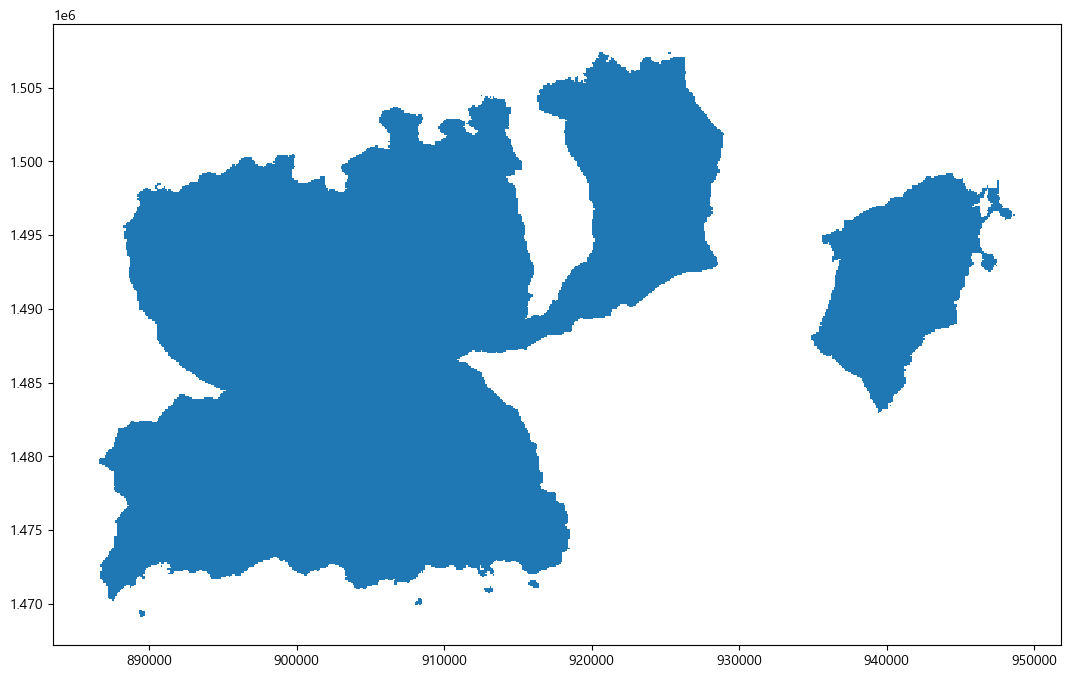

In [50]:
# 그리드 단위 생산가능인구와 상위 10개 존 결합
zone_grid = gpd.sjoin(pop, zone_stru, how = 'inner', op = 'intersects')

# lbl 대신 val 사용
zone_grid.drop('lbl', axis = 1, inplace = True)
zone_grid.plot()

<Axes: >

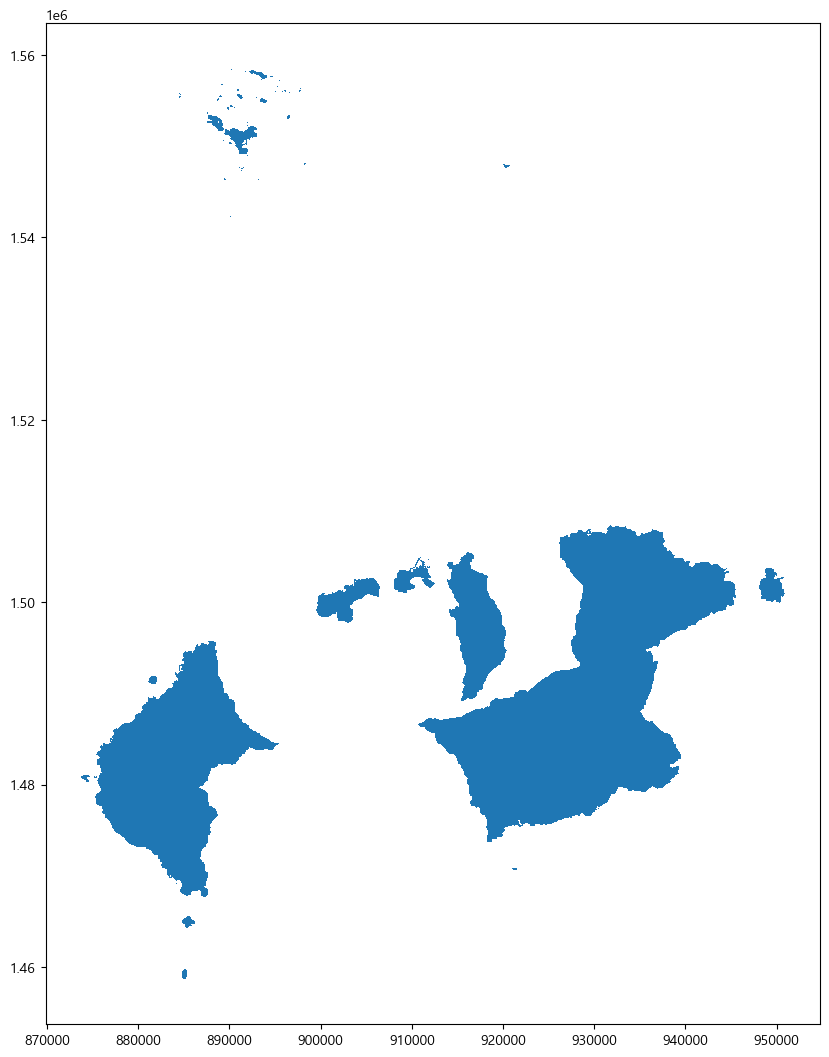

In [51]:
# 그리드 단위 생산가능인구와 상위 10개 존 결합
zone_stop_grid = gpd.sjoin(pop, zone_stop, how = 'inner', op = 'intersects')

# lbl 대신 val 사용
zone_stop_grid.drop('lbl', axis = 1, inplace = True)
zone_stop_grid.plot()

<Axes: >

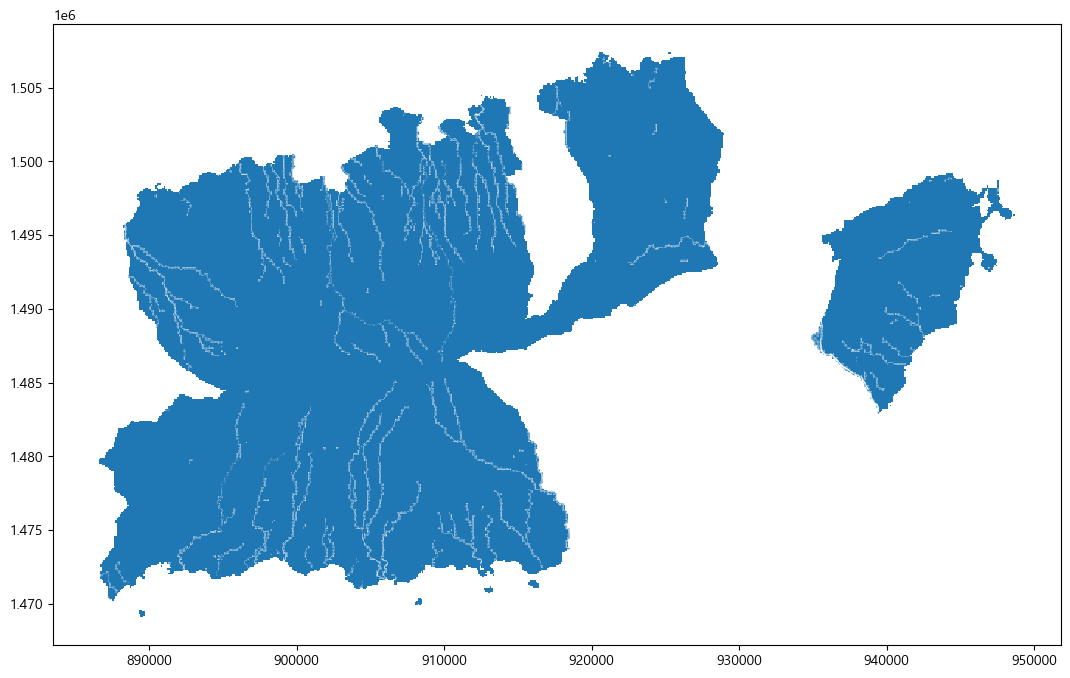

In [52]:
# 상위 행정동에서 하천경계 제외
zone_grid2 = gpd.overlay(zone_grid, river, how = 'difference', keep_geom_type = True)

zone_grid2.drop(['index_right', 'BASE_DATE', 'ADM_CD', '시도', '시군구', '행정동코드'], axis =1, inplace = True)
zone_grid2.plot()

<Axes: >

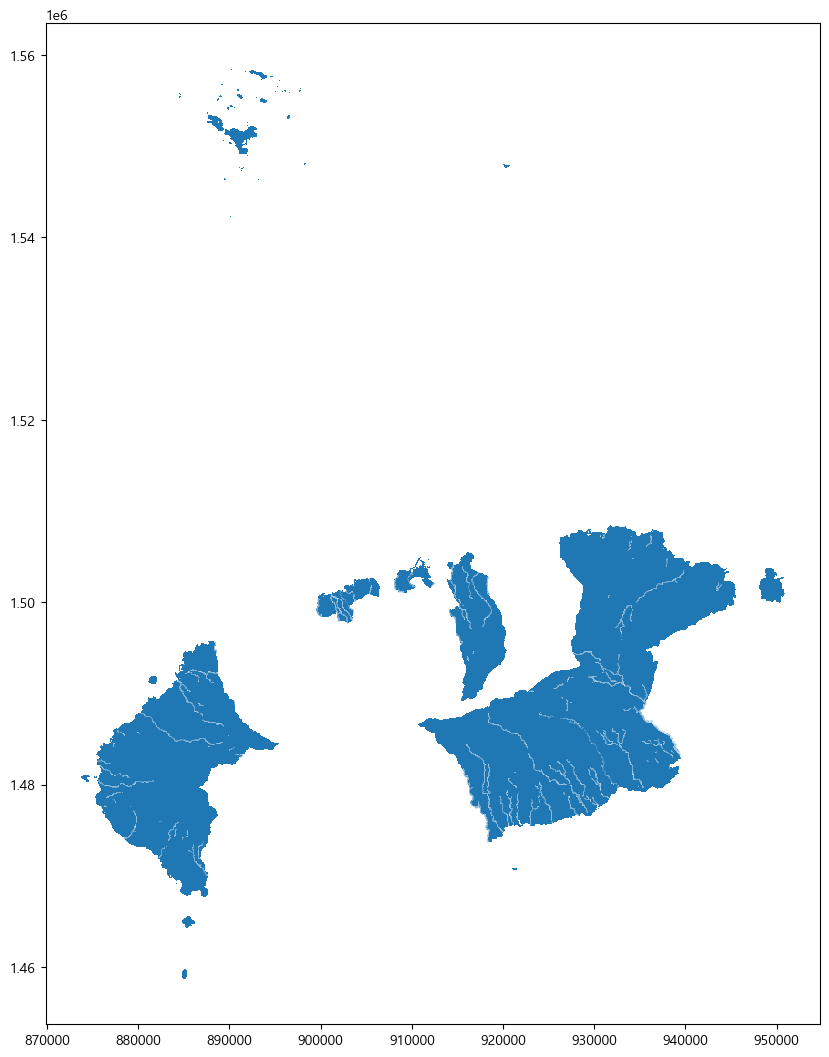

In [53]:
# 상위 행정동에서 하천경계 제외
zone_stop_grid2 = gpd.overlay(zone_stop_grid, river, how = 'difference', keep_geom_type = True)

zone_stop_grid2.drop(['index_right', 'BASE_DATE', 'ADM_CD', '시도', '시군구', '행정동코드'], axis =1, inplace = True)
zone_stop_grid2.plot()

<Axes: >

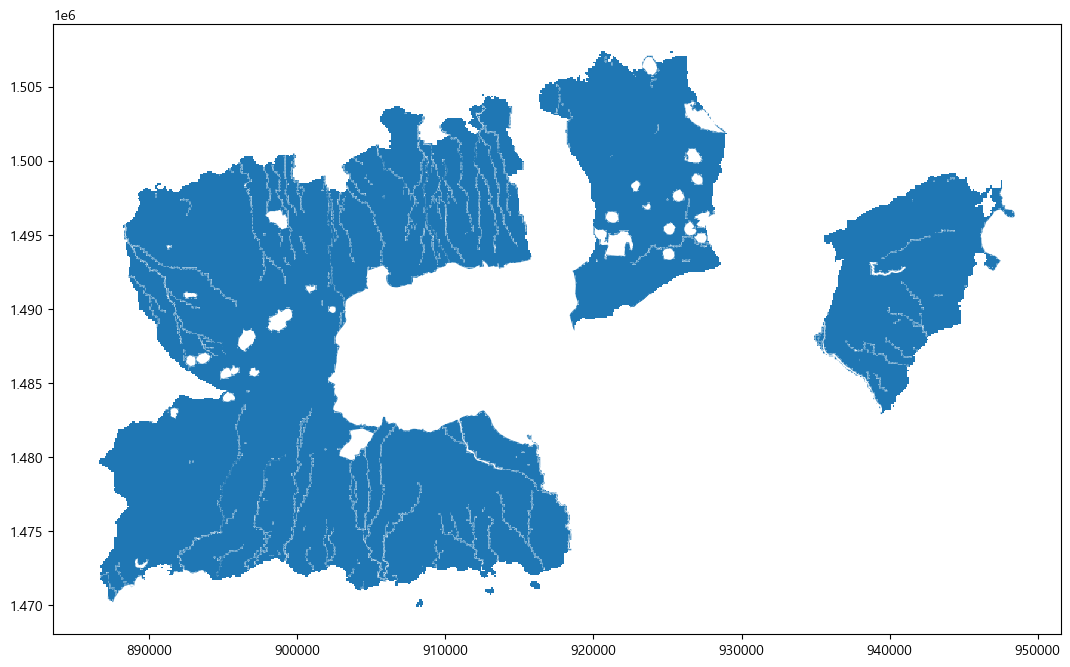

In [54]:
# 자연환경보전지역 제외

zone_grid3 = gpd.overlay(zone_grid2, env, how = 'difference', keep_geom_type = True)
zone_grid3.plot()

<Axes: >

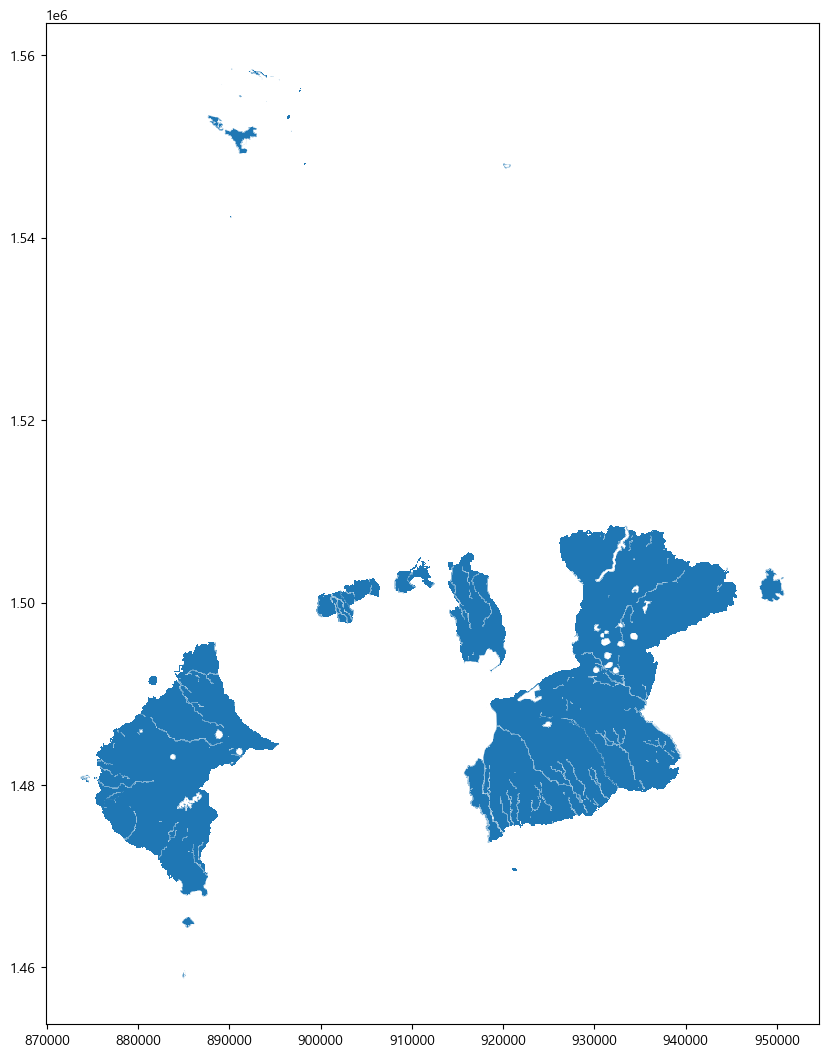

In [55]:
# 자연환경보전지역 제외

zone_stop_grid3 = gpd.overlay(zone_stop_grid2, env, how = 'difference', keep_geom_type = True)
zone_stop_grid3.plot()

<Axes: >

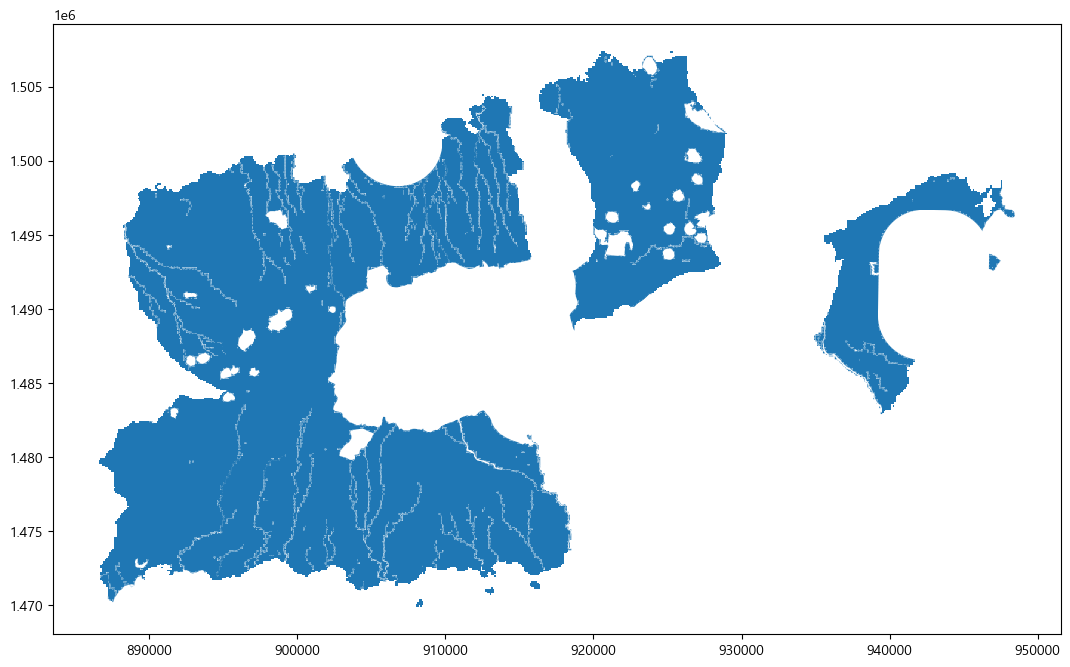

In [56]:
# 버티포트 입지로 최우선순위인 제주공항 구역과 제2공항 부지 제외
# 버티포트 최소 설치 간격인 3km를 감안하여 3km 크기의 버퍼 생성하여 버퍼와 함꼐 제외

port_buff = gpd.GeoDataFrame(airport.geometry.buffer(3000))
port_buff.columns = ['geometry']
port_buff = port_buff.set_geometry('geometry')

port2_buff = gpd.GeoDataFrame(airport_2.geometry.buffer(3000))
port2_buff.columns = ['geometry']
port2_buff = port2_buff.set_geometry('geometry')

zone_grid4 = gpd.overlay(zone_grid3, port_buff, how = 'difference', keep_geom_type = True)
zone_grid4 = gpd.overlay(zone_grid4, port2_buff, how = 'difference', keep_geom_type = True)

zone_grid4.plot()

<Axes: >

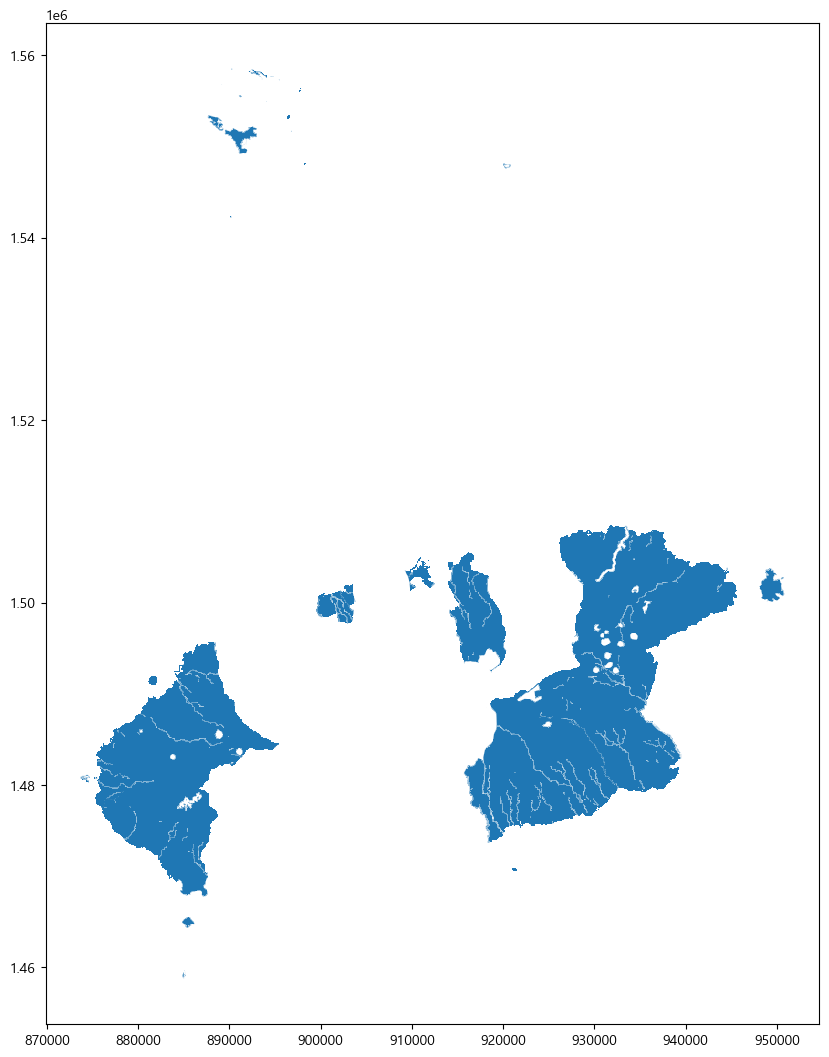

In [57]:
# 버티포트 입지로 최우선순위인 제주공항 구역과 제2공항 부지 제외
# 버티포트 최소 설치 간격인 3km를 감안하여 3km 크기의 버퍼 생성하여 버퍼와 함꼐 제외

port_stop_buff = gpd.GeoDataFrame(airport.geometry.buffer(3000))
port_stop_buff.columns = ['geometry']
port_stop_buff = port_stop_buff.set_geometry('geometry')

port2_stop_buff = gpd.GeoDataFrame(airport_2.geometry.buffer(3000))
port2_stop_buff.columns = ['geometry']
port2_stop_buff = port2_stop_buff.set_geometry('geometry')

zone_stop_grid4 = gpd.overlay(zone_stop_grid3, port_stop_buff, how = 'difference', keep_geom_type = True)
zone_stop_grid4 = gpd.overlay(zone_stop_grid4, port2_stop_buff, how = 'difference', keep_geom_type = True)

zone_stop_grid4.plot()

In [58]:
# 격자단위 인구수와 필지단위 공시지가 결합
zone_grid5 = gpd.sjoin(zone_grid4, gongsi, how = 'inner', op = 'intersects')

# 공간이 겹치는 경우 평균값으로 대체
zone_grid5 = gpd.GeoDataFrame(zone_grid5.groupby(['gid','geometry','ADM_NM','val']).mean().reset_index(),
                              geometry = 'geometry')

# 토지 면적의 경우, 개별공시지가가 존재하지만 토지면적이 기록되지 않는 경우가 많아 분석에서 제외
zone_grid5.drop('A13', axis = 1, inplace = True)

In [59]:
# 격자단위 인구수와 필지단위 공시지가 결합
zone_stop_grid5 = gpd.sjoin(zone_stop_grid4, gongsi, how = 'inner', op = 'intersects')

# 공간이 겹치는 경우 평균값으로 대체
zone_stop_grid5 = gpd.GeoDataFrame(zone_stop_grid5.groupby(['gid','geometry','ADM_NM','val']).mean().reset_index(),
                              geometry = 'geometry')

# 토지 면적의 경우, 개별공시지가가 존재하지만 토지면적이 기록되지 않는 경우가 많아 분석에서 제외
zone_stop_grid5.drop('A13', axis = 1, inplace = True)

In [60]:
# 주차장 접근성과 결합
zone_grid6 = gpd.sjoin(zone_grid5, park, how = 'inner', op = 'intersects', lsuffix = 'left_'
                      , rsuffix = 'right_')

# 공간이 겹칠 경우 주차장 접근성 값을 평균값으로 대체
zone_grid6 = gpd.GeoDataFrame(zone_grid6.groupby(['gid_left_','geometry','ADM_NM', 'val', 'A9']).mean().reset_index(),
                              geometry = 'geometry')

zone_grid6.drop(['존번호','index_right','index_right_'], axis = 1, inplace = True)

In [61]:
# 주차장 접근성과 결합
zone_stop_grid6 = gpd.sjoin(zone_stop_grid5, park, how = 'inner', op = 'intersects', lsuffix = 'left_'
                      , rsuffix = 'right_')

# 공간이 겹칠 경우 주차장 접근성 값을 평균값으로 대체
zone_stop_grid6 = gpd.GeoDataFrame(zone_stop_grid6.groupby(['gid_left_','geometry','ADM_NM', 'val', 'A9']).mean().reset_index(),
                              geometry = 'geometry')

zone_stop_grid6.drop(['존번호','index_right','index_right_'], axis = 1, inplace = True)

In [62]:
# 링크단위 교통량과 격자 결합
zone_grid7 = gpd.sjoin(zone_grid6, link_merge, how = 'left', op = 'intersects')

# ocpy_rate(점유율 제거)
zone_grid7.drop('ocpy_rate', axis = 1, inplace = True)

# 공간이 겹치는 경우 합으로 대체
zone_grid7 = gpd.GeoDataFrame(zone_grid7.groupby(['gid_left_','geometry','ADM_NM','val','A9', 'value']).sum().reset_index(),
                              geometry = 'geometry')

zone_grid7.drop(['index_right', 'sped', 'trvl_hh'], axis = 1, inplace = True)

In [63]:
# 링크단위 교통량과 격자 결합
zone_stop_grid7 = gpd.sjoin(zone_stop_grid6, link_merge, how = 'left', op = 'intersects')

# ocpy_rate(점유율 제거)
zone_stop_grid7.drop('ocpy_rate', axis = 1, inplace = True)

# 공간이 겹치는 경우 합으로 대체
zone_stop_grid7 = gpd.GeoDataFrame(zone_stop_grid7.groupby(['gid_left_','geometry','ADM_NM','val','A9', 'value']).sum().reset_index(),
                              geometry = 'geometry')

zone_stop_grid7.drop(['index_right', 'sped', 'trvl_hh'], axis = 1, inplace = True)

- sped와 trvl_hh는 평균값으로 대체하려 했으나, 0인 값 때문에 결측치(NaN)가 발생하여 분석에서 제외하였음

In [64]:
zone_grid7.head()

,gid_left_,geometry,ADM_NM,val,A9,value,tfvl
0,나나866795,"POLYGON ((886600.000 1479500.000, 886600.000 1...",안덕면,0.0,14314.285714,4.1735,0.0
1,나나866796,"POLYGON ((886600.000 1479600.000, 886600.000 1...",안덕면,0.0,11566.666667,4.4350,0.0
2,나나866797,"POLYGON ((886600.000 1479700.000, 886600.000 1...",안덕면,0.0,15033.333333,4.4350,0.0
3,나나867717,"POLYGON ((886700.000 1471700.000, 886700.000 1...",안덕면,0.0,28841.666667,1.7240,0.0
4,나나867718,"MULTIPOLYGON (((886700.000 1471884.711, 886703...",안덕면,0.0,39429.411765,1.7240,0.0


In [65]:
zone_stop_grid7.head()

,gid_left_,geometry,ADM_NM,val,A9,value,tfvl
0,나나739806,"POLYGON ((873900.000 1480700.000, 873939.868 1...",한경면,0.0,5960.0,-999.0,0.0
1,나나739807,"MULTIPOLYGON (((874000.000 1480800.000, 874000...",한경면,0.0,9520.0,-999.0,0.0
2,나나739808,"MULTIPOLYGON (((874000.000 1480800.000, 873973...",한경면,0.0,8660.0,-999.0,0.0
3,나나739809,"POLYGON ((873900.000 1481000.000, 874000.000 1...",한경면,0.0,6080.0,-999.0,0.0
4,나나740806,"POLYGON ((874000.000 1480690.136, 874004.002 1...",한경면,0.0,11090.0,-999.0,0.0


In [71]:
# 격자 중심점과 전기차충전소들 간 거리중 최소인 거리를 리스트에 할당
# zone_grid_cen = gpd.GeoDataFrame({'gid':zone_grid7['gid_left_'], 'geometry':zone_grid7.geometry.centroid})
zone_grid_cen = gpd.GeoDataFrame({'gid':zone_grid7['gid_left_'], 'geometry':zone_grid7.geometry.centroid})
zone_stop_grid_cen = gpd.GeoDataFrame({'gid':zone_stop_grid7['gid_left_'], 'geometry':zone_stop_grid7.geometry.centroid})

def closet_distance(cen, df):
    all_distance, min_distance = [], []
    total_rows = len(cen)
    
    df_geometry = np.array(df['geometry'])
    
    for idx, row in tqdm(cen.iterrows(), total=total_rows, desc='Outer loop'):
        distances = np.array([row.geometry.distance(geom) for geom in df_geometry])
        all_distance.extend(distances)
        min_distance.append(distances.min())
        
    return min_distance

In [73]:
# tour_mindis = closet_distance(zone_grid_cen, tour_gps)
tour_stop_mindis = closet_distance(zone_stop_grid_cen, tour_gps)

Outer loop: 100%|███████████████████████████████████████████████████████████████| 81492/81492 [08:07<00:00, 167.01it/s]


In [74]:
# zone_grid7['tour_mindis'] = tour_mindis
zone_stop_grid7['tour_mindis'] = tour_stop_mindis

In [75]:
# elec_mindis = closet_distance(zone_grid_cen, elecvehi_gps)
elec_stop_mindis = closet_distance(zone_stop_grid_cen, elecvehi_gps)

Outer loop: 100%|██████████████████████████████████████████████████████████████| 81492/81492 [1:39:39<00:00, 13.63it/s]


In [76]:
# zone_grid7['dis_elec'] = elec_mindis
zone_stop_grid7['dis_elec'] = elec_stop_mindis

In [77]:
# bus_mindis = closet_distance(zone_grid_cen, bus_gps)
bus_stop_mindis = closet_distance(zone_stop_grid_cen, bus_gps)

Outer loop: 100%|██████████████████████████████████████████████████████████████| 81492/81492 [1:28:57<00:00, 15.27it/s]


In [78]:
# zone_grid7['dis_bus'] = bus_mindis
zone_stop_grid7['dis_bus'] = bus_stop_mindis

------------------------------------------------------------------------------------------------------------------------------
# 3. 입지 선정

### MinMax 정규화
- 데이터의 단위가 다르기 때문에 정규화를 통해 단위를 통합한다.
- 0~1사이의 값으로 할당
- (max(x.list) - x) / max(x.list)

In [105]:
# MinMax Scaler
scaler = MinMaxScaler()
# zone_scaled = pd.DataFrame(scaler.fit_transform(zone_grid7.iloc[:,3:10]))
zone_stop_scaled = pd.DataFrame(scaler.fit_transform(zone_stop_grid7.iloc[:,3:10]))

# zone_scaled = pd.concat([zone_grid7.iloc[:,0:3], zone_scaled], axis = 1)
zone_stop_scaled = pd.concat([zone_stop_grid7.iloc[:,0:3], zone_stop_scaled], axis = 1)

In [106]:
zone_stop_grid7.columns

Index(['gid_left_', 'geometry', 'ADM_NM', 'val', 'A9', 'value', 'tfvl',
       'tour_mindis', 'dis_elec', 'dis_bus'],
      dtype='object')

In [107]:
# zone_scaled.columns = ['gid', 'geometry', 'ADM_NM', 'pop', 'price_mean', 'park_access', 'traffic_sum', 'min_dis_elec', 'min_dis_bus']
zone_stop_scaled.columns = ['gid', 'geometry', 'ADM_NM', 'pop', 'price_mean', 'park_access', 'traffic_sum', 'tour_mindis', 'min_dis_elec', 'min_dis_bus']

In [110]:
# zone_scaled.describe()
zone_stop_scaled.describe()

,pop,price_mean,park_access,traffic_sum,tour_mindis,min_dis_elec,min_dis_bus
count,81492.000000,81492.000000,81492.000000,81492.000000,81492.000000,81492.000000,81492.000000
mean,0.001555,0.014170,0.973731,0.000320,0.049406,0.034451,0.021667
std,0.014146,0.027165,0.126543,0.011971,0.037786,0.026578,0.073883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.003562,0.988379,0.000000,0.024742,0.016186,0.006139
50%,0.000000,0.007862,0.989606,0.000000,0.041619,0.029067,0.011652
75%,0.000000,0.015023,0.991436,0.000000,0.063874,0.046799,0.021329
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [131]:
zone_stop_scaled.to_file('./데이터/격자단위_통합데이터셋/버티스탑_통합데이터셋.shp', encoding = 'utf-8')
# zone_scaled.to_file('./데이터/격자단위_통합데이터셋/통합데이터셋.shp', encoding = 'utf-8')

In [112]:
# zone_scaled_ = './데이터/격자단위_통합데이터셋/통합데이터셋.shp'
# zone_scaled = gpd.read_file(zone_scaled_, encoding = 'utf-8')
# zone_scaled.geometry = zone_scaled.geometry.set_crs('EPSG:5179')

#### 모든 독립변수의 관측값들을 합산하여 최종 스코어 선정
- 평균 개별공시지가의 경우, 공시지가가 낮은 곳이 버티포트 및 스탑의 설치가 용이한 것으로 판단하였음
  - 따라서 최대값 1과 관측값과의 차이로 변환하여 합산
- 격자와 버스정류장과의 최소 거리의 경우, 최소 거리가 작은 곳이 접근성이 용이한 것으로 판단하였음
  - 따라서 최대값 1과 관측값과의 차이로 변환하여 합산
- 격자와 전기차충전소와의 최 소거리의 경우, 최소 거리가 작은 곳이 접근성이 용이한 것으로 판단하였음
  - 따라서 최대값 1과 관측값과의 차이로 변환하여 합산
- 격자와 관광지와의 최 소거리의 경우, 최소 거리가 작은 곳이 접근성이 용이한 것으로 판단하였음
  - 따라서 최대값 1과 관측값과의 차이로 변환하여 합산

In [114]:
def score(df):
    return [row['pop'] + (1-row['price_mean']) + row['park_access'] + row['traffic_sum'] + (1-row['tour_mindis']) + (1 - row['min_dis_elec']) + (1- row['min_dis_bus']) for idx, row in df.iterrows()]

# zone_scaled['score'] = score(zone_scaled)
zone_stop_scaled['score'] = score(zone_stop_scaled)

## 버티포트 입지선정
- 독립변수들 간의 연산을 통한 값으로 입지를 선정한다.
- 버티포트의 경우 300m 버퍼로 표현한다.

In [115]:
# 버티포트의 경우 그리드가 선택되면 300m X 300m 버퍼로 변환한다.
# 버티스탑의 경우 그리드가 선택되면 200m X 200m 버퍼로 변환한다.

def buffer_Vertiport(df):
    for i in range(len(df)):
        location = df.geometry.iloc[i]
        ax = gpd.GeoSeries(location.buffer(300).envelope).plot(color= 'skyblue')
        
def buffer_Vertistop(df):
    for i in range(len(df)):
        location = df.geometry.iloc[i]
        ax = gpd.GeoSeries(location.buffer(200).envelope).plot(color= 'skyblue')
        
def location_selection(df):
    gid, score, geometry = [], [], []

    pbar_outer = tqdm(total=len(df), desc='완료')

    while len(df) > 0:
        base_geometry = df.iloc[0]['geometry']  # 첫 번째 행의 geometry를 기준으로 사용

        distances = df['geometry'].apply(lambda x: base_geometry.distance(x) <= 3000)
        within_radius = df[distances]

        gid.append(within_radius['gid'].tolist()[0])
        score.append(within_radius['score'].tolist()[0])
        geometry.append(within_radius['geometry'].tolist()[0])

        df = df.drop(within_radius.index)
        df = df.sort_values(by='score', ascending=False)

        pbar_outer.update(len(within_radius))
    
    pbar_outer.close()

    return df, gid, score, geometry

In [116]:
# df = zone_scaled.sort_values(by = 'score', ascending = False)

# df2, gid, score, geometry = location_selection(df)

In [117]:
# port_location = gpd.GeoDataFrame({'gid':gid, 'score':score, 'geometry':geometry}, geometry = 'geometry')
# port_location

In [118]:
# port_buff = gpd.GeoDataFrame({'geometry': port_location.geometry.buffer(300)}) # 300m X 300m 버퍼 생성

In [119]:
# port_location.to_file('./데이터/입지선정_결과/임시.shp', encoding = 'utf-8')
# port_buff.to_file('./데이터/입지선정_결과/임시_버퍼.shp', encoding = 'utf-8')

## 버티스탑 입지선정
- 버티스탑의 경우, 헬리패드 위치를 우선 선정한다.
- 그 이후 헬리패드 위치에서 3km 이내를 제외한다.
- 또한 선정된 버티포트들의 3km 버퍼를 제외한 나머지 그리드 중 버티스탑 입지를 선정한다.
- 버티스탑은 200m 버퍼로 표현한다.

In [120]:
# 헬리패드 위치정보 로드
helli_gps_ = './데이터/헬기장 목록/제주시 헬리패드 위치.shp'
helli_gps = gpd.read_file(helli_gps_, encoding = 'utf-8')
helli_gps.geometry = helli_gps.geometry.set_crs('EPSG:5186')
helli_gps.geometry = helli_gps.geometry.to_crs('EPSG:5179')

In [121]:
helli_gps.head()

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,geometry
0,한라생태숲,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,POINT Z (915915.234 1493718.627 0.000)
1,새별오름(주차장),NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,POINT Z (894017.412 1485974.135 0.000)
2,구좌체육관(주차장),NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,POINT Z (931474.457 1507286.401 0.000)
3,충혼묘지,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,POINT Z (906287.653 1492406.541 0.000)
4,제주대학병원,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,POINT Z (911226.682 1497726.823 0.000)


In [122]:
# 버티포트 입지 제외
port_location_result_ = './데이터/입지선정_결과/버티포트 입지.shp'
port_location_result = gpd.read_file(port_location_result_, encoding = 'utf-8')
port_location_result.geometry = port_location_result.geometry.set_crs('EPSG:4326')
port_location_result.geometry = port_location_result.geometry.to_crs('EPSG:5179')

In [123]:
port_location_result

,gid,score,id,layer,path,geometry
0,나나890960,4.924629,NaN,곽지,/Users/kyubacksong/Desktop/공모전/입지선정/곽지.shp,"POLYGON ((889000.000 1496000.000, 889000.000 1..."
1,다다115005,4.268768,NaN,구제주,/Users/kyubacksong/Desktop/공모전/입지선정/구제주.shp,"POLYGON ((911500.000 1500500.000, 911500.000 1..."
2,다나090735,4.108474,NaN,서귀포,/Users/kyubacksong/Desktop/공모전/입지선정/서귀포.shp,"POLYGON ((909000.000 1473500.000, 909000.000 1..."
3,다나441982,3.877132,NaN,성산,/Users/kyubacksong/Desktop/공모전/입지선정/성산.shp,"POLYGON ((944100.000 1498200.000, 944100.000 1..."
4,다나040998,4.002865,NaN,신제주,/Users/kyubacksong/Desktop/공모전/입지선정/신제주.shp,"POLYGON ((904000.000 1499807.537, 904005.077 1..."
5,나나886742,4.921700,NaN,안덕,/Users/kyubacksong/Desktop/공모전/입지선정/안덕.shp,"POLYGON ((888600.000 1474200.000, 888600.000 1..."
6,NaN,NaN,1.0,조천,/Users/kyubacksong/Desktop/공모전/입지선정/조천.shp,"POLYGON ((922683.456 1505303.009, 922977.198 1..."


<Axes: >

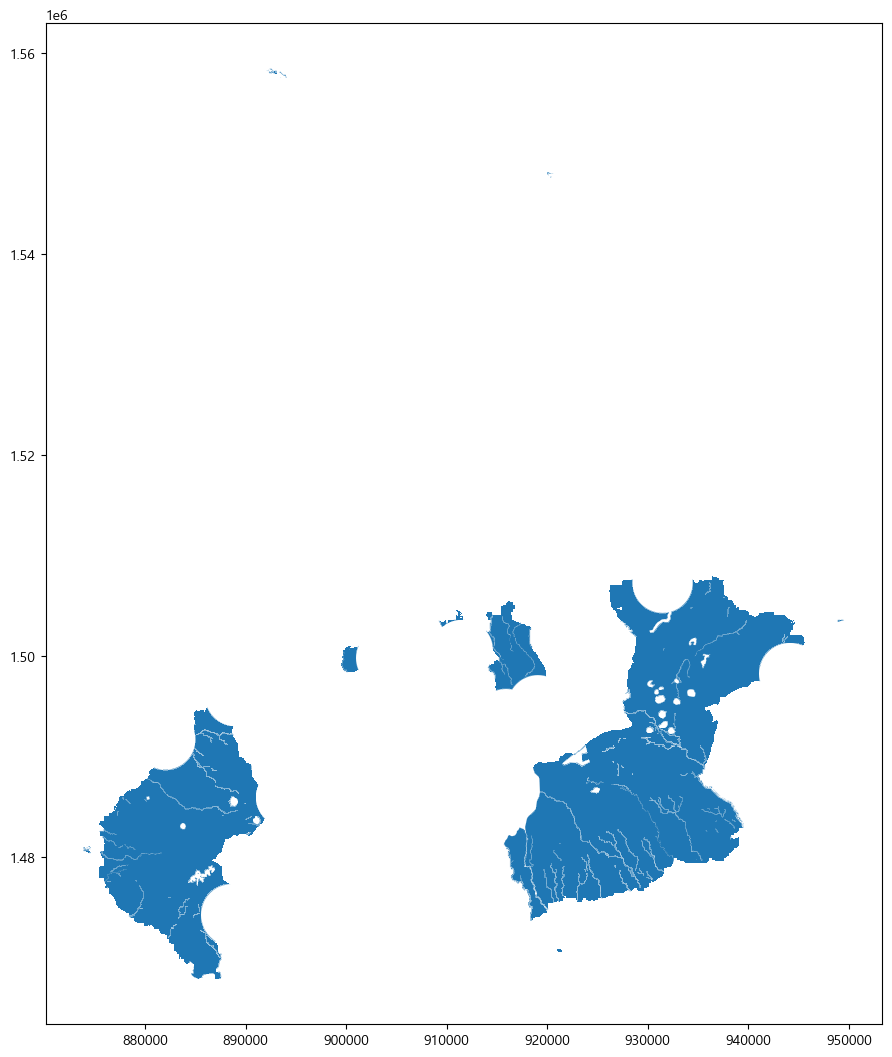

In [124]:
helli_gps_buff = gpd.GeoDataFrame({'geometry':helli_gps.buffer(3000)}) # 버퍼 생성
port_buff_result = gpd.GeoDataFrame({'geometry': port_location_result.geometry.buffer(3000)}) # 300m X 300m 버퍼 생성

zone_stop_scaled = gpd.overlay(zone_stop_scaled, helli_gps_buff, how = 'difference', keep_geom_type = True)
zone_stop_scaled = gpd.overlay(zone_stop_scaled, port_buff_result, how = 'difference', keep_geom_type = True)
zone_stop_scaled.plot()

In [125]:
df = zone_stop_scaled.sort_values(by = 'score', ascending = False)

df2, gid, score, geometry = location_selection(df)

완료: 100%|████████████████████████████████████████████████████████████████████| 72579/72579 [00:21<00:00, 3349.73it/s]


In [126]:
stop_location = gpd.GeoDataFrame({'gid':gid, 'score':score, 'geometry':geometry}, geometry = 'geometry')
stop_location

,gid,score,geometry
0,다다164035,5.806408,"POLYGON ((916400.000 1503500.000, 916400.000 1..."
1,나나864779,5.726682,"POLYGON ((886400.000 1477900.000, 886400.000 1..."
2,다나009997,5.718444,"POLYGON ((900900.000 1499700.000, 900900.000 1..."
3,나나864943,5.585440,"POLYGON ((886400.000 1494400.000, 886465.606 1..."
4,다다277072,5.189581,"POLYGON ((927700.000 1507200.000, 927700.000 1..."
...,...,...,...
71,나나745808,3.921300,"MULTIPOLYGON (((874500.000 1480831.085, 874505..."
72,다다492034,3.864242,"POLYGON ((949200.000 1503500.000, 949254.063 1..."
73,다나210708,3.638891,"POLYGON ((921000.000 1470800.000, 921000.000 1..."
74,나다935575,2.589976,"POLYGON ((893500.000 1557549.784, 893504.076 1..."


<Axes: >

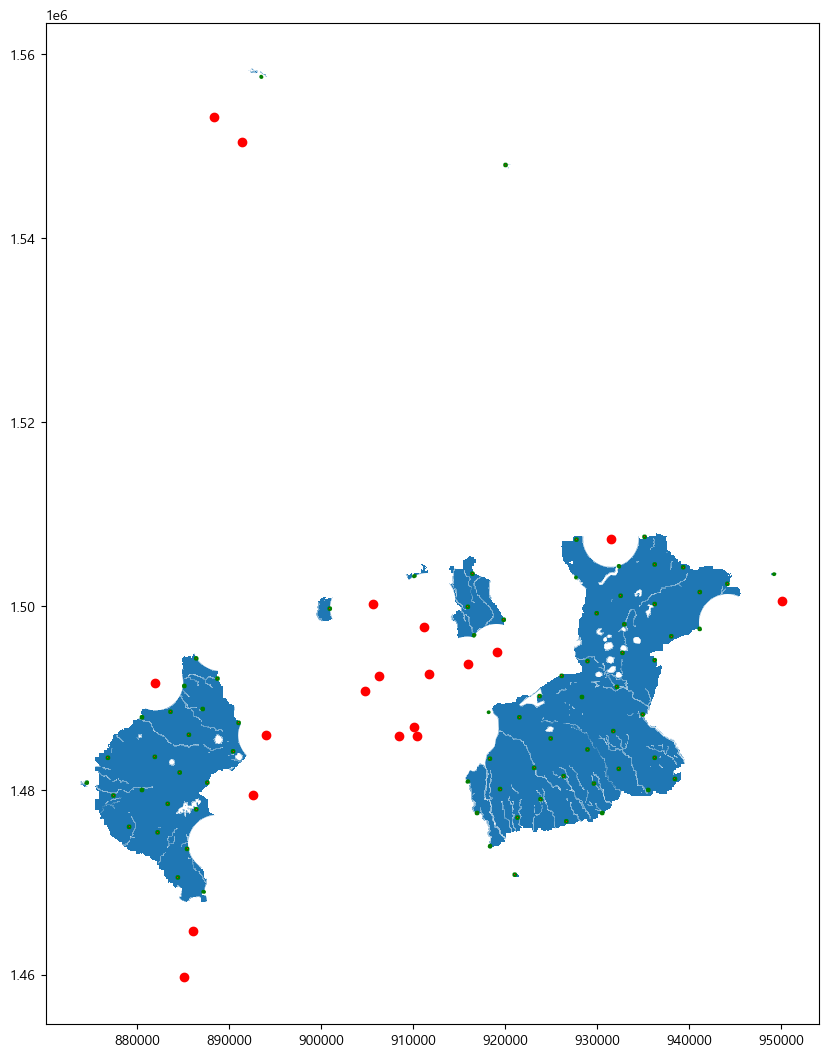

In [128]:
fig, ax = plt.subplots()
zone_stop_scaled.plot(ax= ax)
helli_gps.buffer(200).plot(ax =ax, color = 'green')
helli_gps.plot(ax= ax, color = 'red')
stop_location.buffer(200).plot(ax = ax, color = 'green')
stop_location.plot(ax = ax, color = 'red')

In [129]:
stop_buff = gpd.GeoDataFrame({'geometry': stop_location.geometry.buffer(200)}) # 200m X 200m 버퍼 생성

In [130]:
stop_location.to_file('./데이터/입지선정_결과/버티스탑_입지.shp', encoding = 'utf-8')
stop_buff.to_file('./데이터/입지선정_결과/버티스탑_버퍼.shp', encoding = 'utf-8')